# KELOMPOK 21
**- CHRISTIAN HADI CANDRA (F1D02310108)**  
**- DODI WIJAYA (F1D02310047)**  
**- HILYA FITRI (F1D02310009)**  
**- R. RAFI YUDI PRAMANA (F1D02310132)**

## KLASIFIKASI PATAH TULANG


## IMPORT LIBRARY

In [1]:
import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import entropy
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay)
import seaborn as sns

| **Library** | **Penjelasan** |
|-------------|----------------|
| `os` | Digunakan untuk interaksi dengan sistem file, seperti mengakses direktori, membaca isi folder, dan mengelola path file. Dalam klasifikasi patah tulang, `os` sangat berguna untuk menavigasi struktur folder dataset, seperti mengambil data dari subfolder kelas tertentu menggunakan `os.listdir()` dan `os.path.join()`. |
| `cv2` | OpenCV adalah library utama untuk pemrosesan citra. Digunakan untuk membaca gambar (`cv2.imread`), mengubah ukuran (`cv2.resize`), dan konversi ke grayscale (`cv2.cvtColor`). Juga mendukung filtering, thresholding, dan morfologi (dilasi, erosi), sangat penting dalam membersihkan citra X-ray sebelum ekstraksi fitur. |
| `matplotlib.pyplot` | Digunakan untuk visualisasi gambar dan grafik. Membantu menampilkan hasil preprocessing, prediksi, grafik akurasi, dan confusion matrix. Sangat berguna untuk analisis dan dokumentasi hasil dalam proyek klasifikasi citra patah tulang. |
| `numpy` | Library dasar untuk komputasi numerik. Mewakili citra sebagai array dan digunakan dalam semua tahap manipulasi data, termasuk reshape, mean, std, serta operasi matriks. Hasil ekstraksi fitur juga biasanya disimpan dalam array numpy. |
| `pandas` | Digunakan untuk pengelolaan data tabular dengan `DataFrame`. Sangat berguna untuk menyimpan fitur hasil ekstraksi beserta labelnya. Memudahkan analisis, eksplorasi, dan integrasi dengan model machine learning. Hasil evaluasi juga bisa disimpan ke CSV atau Excel. |


## Data Loading

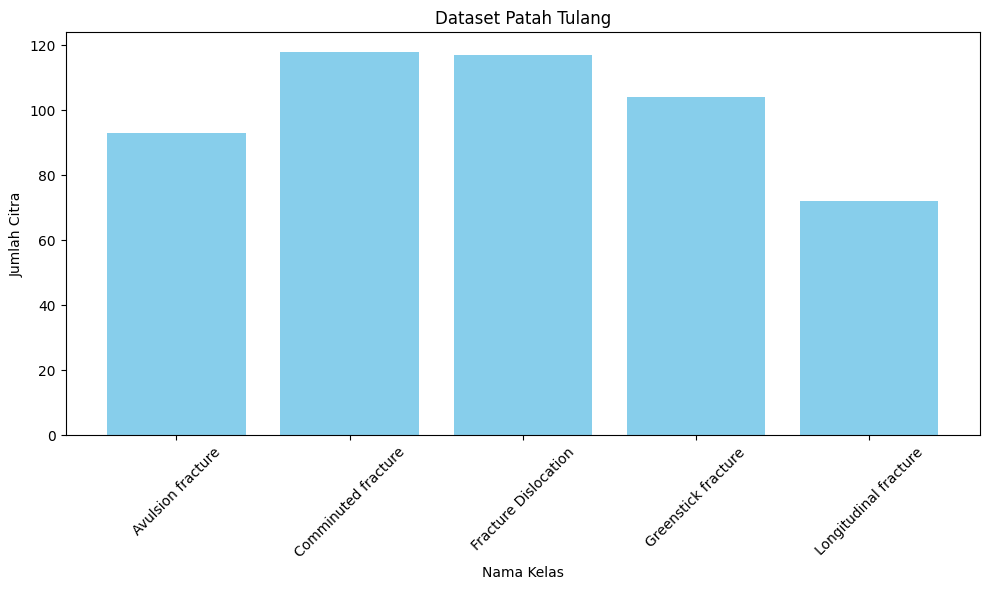

In [2]:
data = []
labels = []
file_name = []
for sub_folder in os.listdir("dataset\\"):
    sub_folder_files = os.listdir(os.path.join("dataset\\", sub_folder))
    for i, filename in enumerate(sub_folder_files):
        img_path = os.path.join("dataset\\", sub_folder, filename)
        img = cv.imread(img_path)
        img = cv.resize(img, (512,512))
        
        data.append(img)
        labels.append(sub_folder)
        name = os.path.splitext(filename)[0]
        file_name.append(filename)
        
data = np.array(data)
labels = np.array(labels)

# Hitung jumlah data tiap kelas manual
class_count = {}
for label in labels:
    if label in class_count:
        class_count[label] += 1
    else:
        class_count[label] = 1

label = list(class_count.keys())
jumlah = list(class_count.values())

# Plot diagram batang
plt.figure(figsize=(10,6))
plt.bar(label, jumlah, color='skyblue')
plt.title("Dataset Patah Tulang")
plt.xlabel("Nama Kelas")
plt.ylabel("Jumlah Citra")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

- Kode di atas berfungsi untuk memuat data citra dari folder yang berstruktur berisi subfolder, di mana setiap subfolder mewakili satu kelas. Pertama, kode melakukan iterasi pada setiap subfolder dalam folder utama `"dataset\\"`, dan memastikan hanya folder yang diproses. Selanjutnya, setiap file gambar di dalam subfolder tersebut dibaca menggunakan OpenCV (`cv.imread`) dan diubah ukurannya menjadi 512x512 piksel agar ukuran citra konsisten. Gambar yang berhasil dimuat kemudian disimpan dalam list `data`, sedangkan nama subfolder (kelas) disimpan ke dalam list `labels`, dan nama file aslinya disimpan dalam `file_name`. Setelah proses pemuatan selesai, list `data` dan `labels` dikonversi ke array NumPy agar lebih mudah diolah.

- Untuk mengetahui distribusi jumlah citra pada setiap kelas, kode membuat sebuah dictionary `class_count` yang menghitung banyaknya kemunculan tiap label secara manual dengan melakukan iterasi pada array `labels`. Jika label sudah ada di dictionary, nilainya ditambah satu; jika belum, dibuat entri baru dengan nilai satu. Dari dictionary ini kemudian dibuat dua list, yaitu `label` yang berisi nama kelas, dan `jumlah` yang berisi jumlah citra masing-masing kelas.

- Terakhir, kode menggunakan `matplotlib` untuk menampilkan diagram batang (bar chart) yang merepresentasikan jumlah citra pada tiap kelas. Label kelas diletakkan di sumbu x, jumlah citra di sumbu y, dengan judul grafik "Dataset Patah Tulang". Agar label kelas yang mungkin cukup panjang tetap terbaca dengan rapi, teks pada sumbu x diputar 45 derajat. Fungsi `plt.tight_layout()` memastikan tata letak grafik tidak tumpang tindih sehingga hasil visualisasi menjadi lebih rapi dan jelas. Dengan demikian, grafik ini memudahkan untuk melihat dan membandingkan jumlah data gambar dari masing-masing kelas pada dataset.

## DEFINE FUNCTION

In [ ]:
def median(citra, kernel_size):
    pad_size = kernel_size // 2
    padded = np.pad(citra, pad_width=pad_size, mode='edge')

    height, width = citra.shape
    result = np.zeros_like(citra)

    for i in range(height):
        for j in range(width):
            area_konvo = padded[i:i+kernel_size, j:j+kernel_size]
            list_konvo = [area_konvo[x][y] for x in range(kernel_size) for y in range(kernel_size)]
            urutkan = np.sort(list_konvo)
            mid = len(urutkan) // 2
            result[i, j] = urutkan[mid]
    return result

def ekualisasi(citra):
    height, width = citra.shape

    hist = np.zeros(256, dtype=int)
    for i in range(height):
        for j in range(width):
            value = citra[i, j]
            hist[value] += 1

    cdf = np.zeros(256, dtype=int)
    for i in range(256):
        cdf[i] = np.sum(hist[:i+1])

    cdf_min = np.min(cdf[cdf > 0])

    norm_cdf = np.round((cdf - cdf_min) / (height * width - cdf_min) * 255)
    norm_cdf = np.minimum(norm_cdf, 255)
    norm_cdf = np.maximum(norm_cdf, 0).astype(np.uint8) 

    citra_eq = np.zeros_like(citra, dtype=np.uint8)
    for i in range(height):
        for j in range(width):
            value = citra[i, j]
            citra_eq[i, j] = norm_cdf[value]

    return citra_eq

def perbaikan_citra(image, kernel):
    img_height, img_width = image.shape
    kernel_height, kernel_width = kernel.shape
    pad_height = kernel_height //2
    pad_width = kernel_width //2
    padded_img =  np.pad(image, ((pad_height, pad_height), (pad_width, pad_width)), mode='edge')
    result = np.zeros([img_height, img_width])

    for i in range(img_height):
        for j in range(img_width):
            result[i, j] = np.sum(padded_img[i:i+kernel_height, j:j+kernel_width] * kernel)
    return result

kernel_sharp = np.array([[0, -1, 0],
                         [-1, 5, -1],
                         [0, -1, 0]])

def konvolusi(image, kernel):
    img_height, img_width = image.shape
    k_height, k_width = kernel.shape
    pad_h = k_height // 2
    pad_w = k_width // 2

    padded_img = np.pad(image, ((pad_h, pad_h), (pad_w, pad_w)), mode='reflect')

    result = np.zeros((img_height, img_width), dtype=np.float64)

    for i in range(img_height):
        for j in range(img_width):
            area_konvo = padded_img[i:i+k_height, j:j+k_width]
            result[i, j] = np.sum(area_konvo * kernel)

    return result

def deteksi_tepi(image, kernelX, kernelY):
    hasilX = konvolusi(image, kernelX)
    hasilY = konvolusi(image, kernelY)

    magnitude = np.sqrt(hasilX**2 + hasilY**2)

    magnitude = cv.convertScaleAbs(magnitude)

    return magnitude

Sx = np.array([[-1, 0, 1], 
               [-2, 0, 2], 
               [-1, 0, 1]])

Sy = np.array([[ 1,  2,  1], 
               [ 0,  0,  0], 
               [-1, -2, -1]])

def prepro2(image):
    gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    img = median(gray, 5)
    img = ekualisasi(img)
    img = perbaikan_citra(img, kernel_sharp)
    img = deteksi_tepi(img, Sx, Sy)
    return img

| No | Fungsi            | Penjelasan                                                                                                                                                                                                                           |
|----|-------------------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| 1  | `median`          | Menerapkan *median filtering* pada citra grayscale untuk menghilangkan noise seperti *salt-and-pepper*. Setiap piksel diganti dengan nilai median dari area sekitarnya, menggunakan padding `'edge'` agar ukuran citra tetap.      |
| 2  | `ekualisasi`      | Meningkatkan kontras citra grayscale dengan teknik *histogram equalization*. Histogram piksel diubah menjadi CDF, lalu dinormalisasi untuk meratakan distribusi intensitas ke rentang 0–255.                                       |
| 3  | `perbaikan_citra` | Melakukan konvolusi citra dengan kernel tertentu seperti `kernel_sharp`. Fungsi ini digunakan untuk penajaman (enhancement) citra agar detail dan tepi objek lebih jelas.                                                          |
| 4  | `konvolusi`       | Melakukan konvolusi citra dengan mode padding `'reflect'`, menghasilkan fleksibilitas untuk berbagai efek seperti deteksi tepi, blur, dan emboss. Nilai piksel dihitung dari penjumlahan hasil perkalian area dan kernel.         |
| 5  | `deteksi_tepi`    | Menggabungkan konvolusi horizontal dan vertikal (dengan `kernelX` dan `kernelY`) untuk mendeteksi tepi. Magnitudo gradien dihitung lalu dikonversi ke format citra 8-bit agar dapat divisualisasikan.                              |
| 6  | `Sx` dan `Sy`     | Kernel Sobel untuk deteksi tepi. `Sx` mendeteksi tepi horizontal, sedangkan `Sy` mendeteksi vertikal. Digunakan dalam kombinasi untuk menangkap arah tepi dalam citra.                                                              |
| 7  | `prepro2`         | Pipeline preprocessing citra: konversi ke grayscale, filtering median, ekualisasi histogram, penajaman dengan `kernel_sharp`, dan deteksi tepi dengan Sobel. Hasil akhir adalah citra dengan tepi yang tajam untuk analisis lanjut. |


### ANALISIS PENGGUNAAN PRE-PROCESSING:

- Awalnya, tahapan pre-processing yang digunakan hanya melibatkan sharpening dan deteksi tepi menggunakan operator Sobel. Meskipun pendekatan ini cukup efektif untuk menonjolkan kontur dan tepi objek pada citra, hasil akurasi yang diperoleh masih belum maksimal. Oleh karena itu, dilakukan pengembangan terhadap tahapan pre-processing dengan menambahkan beberapa langkah penting untuk meningkatkan kualitas citra yang akan diklasifikasikan. Salah satu tahapan yang ditambahkan adalah penggunaan median filter, yang berfungsi untuk menghilangkan noise tipe salt-and-pepper tanpa mengaburkan detail pada tepi objek. Dengan demikian, fitur halus seperti garis patahan tetap dapat dipertahankan. Selanjutnya, dilakukan ekualisasi histogram untuk meningkatkan kontras secara keseluruhan, sehingga struktur tulang maupun retakan menjadi lebih jelas dan mudah dikenali.

- Selain itu, ditambahkan proses closing—gabungan dari dilasi dan erosi—yang bertujuan untuk menyambungkan garis-garis patahan yang mungkin terputus akibat noise atau variasi intensitas, sehingga menghasilkan garis yang lebih utuh dan mudah dikenali. Citra hasil dari proses sharpening dan hasil dari proses closing kemudian digabungkan dengan bobot tertentu agar menciptakan representasi visual yang kaya akan informasi baik dari sisi tekstur maupun kontur. Terakhir, dilakukan normalisasi intensitas agar semua nilai piksel berada pada rentang yang konsisten, yang penting untuk memastikan model klasifikasi dapat bekerja secara optimal. Secara keseluruhan, pengembangan pre-processing ini bertujuan untuk meningkatkan kualitas citra input dengan menonjolkan fitur penting dan mengurangi gangguan, sehingga model dapat mendeteksi patahan tulang dengan lebih akurat dan andal.

## PROSES PREPROSESSING

In [ ]:
dataPreprocessed = []

for i in range(len(data)):
    img = data[i]
    preprocessed_img = prepro2(img)
    dataPreprocessed.append(preprocessed_img)

Kode tersebut bertujuan untuk melakukan proses preprocessing pada seluruh citra yang telah dimuat sebelumnya ke dalam variabel `data`. Proses ini dimulai dengan membuat sebuah list kosong bernama `dataPreprocessed` yang akan menampung hasil citra yang telah diproses. Selanjutnya, kode melakukan iterasi terhadap setiap citra di dalam `data` menggunakan indeks `i`. Pada setiap iterasi, citra yang diambil dari `data` kemudian diproses melalui sebuah fungsi bernama `prepro3()`, yang berfungsi melakukan langkah-langkah preprocessing tertentu, seperti normalisasi, penghapusan noise, atau transformasi lain yang diperlukan untuk mempersiapkan citra agar siap digunakan dalam tahap analisis atau pelatihan model. Setelah citra selesai diproses oleh fungsi tersebut, hasilnya disimpan ke dalam list `dataPreprocessed`. Dengan demikian, setelah seluruh citra diproses, `dataPreprocessed` akan berisi kumpulan citra yang sudah siap dan telah melewati tahapan preprocessing, yang biasanya sangat penting untuk meningkatkan kualitas dan konsistensi data sebelum digunakan dalam aplikasi berikutnya.

## AUGMENTASI

In [11]:
def rotasi(image, theta_deg):
    theta = np.radians(theta_deg)
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)

    height, width = image.shape
    rotasi_img = np.zeros_like(image)

    cx, cy = width // 2, height // 2

    for i in range(height):
        for j in range(width):
            x_new = j - cx
            y_new = i - cy

            x_orig = x_new * cos_theta + y_new * sin_theta
            y_orig = -x_new * sin_theta + y_new * cos_theta

            x_orig += cx
            y_orig += cy

            if 0 <= x_orig < width and 0 <= y_orig < height:
                rotasi_img[i, j] = image[int(y_orig), int(x_orig)]

    return rotasi_img

def flip_horizontal(image):
    img_flipped = np.zeros_like(image)
    rows, cols =image.shape
    for i in range(rows):
        for j in range(cols):
            img_flipped[i,j]=image[i, cols - 1-j]
    return img_flipped

def flip_vertical(image):
    img_flipped = np.zeros_like(image)
    rows, cols =image.shape
    for i in range(rows):
        for j in range(cols):
            img_flipped[i,j]=image[rows-1-i,j]
    return img_flipped

| Fungsi                | Deskripsi                                                                                       | Efek pada Citra                                    |
|-----------------------|------------------------------------------------------------------------------------------------|---------------------------------------------------|
| `rotasi(image, theta_deg)`     | Memutar citra sebesar sudut tertentu menggunakan transformasi rotasi berbasis matriks.         | Citra berputar dengan sudut yang diberikan tanpa merubah proporsi utama. |
| `flip_horizontal(image)` | Membalik citra secara horizontal dengan membalik posisi piksel dari kiri ke kanan.             | Citra menjadi cermin secara horizontal (kiri-kanan tertukar).            |
| `flip_vertical(image)`   | Membalik citra secara vertikal dengan membalik posisi piksel dari atas ke bawah.               | Citra menjadi cermin secara vertikal (atas-bawah tertukar).             |


## PROSES AUGMENTASI

In [12]:
data_augmented = []
labels_augmented = []
paths_augmented = []
file_name_augmented = []
for i in range(len(dataPreprocessed)):
    img = dataPreprocessed[i]
    label = labels[i]
    fname = file_name[i]

    # Data asli
    data_augmented.append(img)
    labels_augmented.append(label)
    file_name_augmented.append(fname + "_original")

    # Rotasi 45
    img_rot45 = rotasi(img, 45)
    data_augmented.append(img_rot45)
    labels_augmented.append(label)
    file_name_augmented.append(fname + "_rot45")
    img_fliph = flip_horizontal(img)
    data_augmented.append(img_fliph)
    labels_augmented.append(label)
    file_name_augmented.append(fname + "_fliph")

    # Flip vertical
    img_flipv = flip_vertical(img)
    data_augmented.append(img_flipv)
    labels_augmented.append(label)
    file_name_augmented.append(fname + "_flipv")

Kode tersebut melakukan proses augmentasi data citra yang sudah melalui tahap preprocessing sebelumnya, yang disimpan dalam `dataPreprocessed`. Pada setiap iterasi, citra dan label aslinya serta nama file terkait diambil berdasarkan indeks yang sama. Pertama, citra asli ditambahkan ke dalam list baru `data_augmented` bersama dengan label dan nama file yang diberi akhiran "\_original" untuk menandakan data asli. Selanjutnya, citra tersebut diproses dengan fungsi `rotasi` untuk memutar gambar sebesar 45 derajat, hasil rotasi ini juga disimpan ke dalam `data_augmented` dengan label yang sama dan nama file yang diakhiri dengan "\_rot". Setelah itu, citra juga dibalik secara horizontal menggunakan fungsi `flip_horizontal`, dan hasilnya disimpan dengan nama file yang diakhiri "\_fliph". Terakhir, citra juga dibalik secara vertikal menggunakan fungsi `flip_vertical`, dan hasilnya dimasukkan ke dalam dataset augmentasi dengan nama file berakhiran "\_flipv". Dengan demikian, dari setiap citra asli dihasilkan beberapa variasi baru yang memperkaya dataset, yang nantinya dapat membantu model machine learning untuk belajar dari data yang lebih beragam dan meningkatkan kemampuan generalisasi pada tugas klasifikasi atau pengenalan citra.


In [13]:
print("Data sebelum augmentasi: ", len(data))
print("Data setelah augmentasi: ", len(data_augmented))

Data sebelum augmentasi:  504
Data setelah augmentasi:  2016


Kode tersebut berfungsi untuk menampilkan perbandingan jumlah data citra sebelum dan sesudah proses augmentasi. Baris pertama `print("Data sebelum augmentasi: ", len(data))` mencetak jumlah citra asli yang telah dimuat ke dalam variabel `data` sebelum dilakukan penambahan variasi. Sedangkan baris kedua `print("Data setelah augmentasi: ", len(data_augmented))` mencetak jumlah citra setelah proses augmentasi, yang mencakup citra asli beserta semua variasi hasil rotasi dan pembalikan (flip) yang telah dibuat. Dengan menampilkan kedua angka ini, kita dapat melihat secara jelas berapa banyak data tambahan yang berhasil dihasilkan melalui teknik augmentasi, sehingga dataset menjadi lebih besar dan lebih bervariasi untuk meningkatkan kualitas pelatihan model machine learning.

## MENAMPILKAN SAMPLE GAMBAR

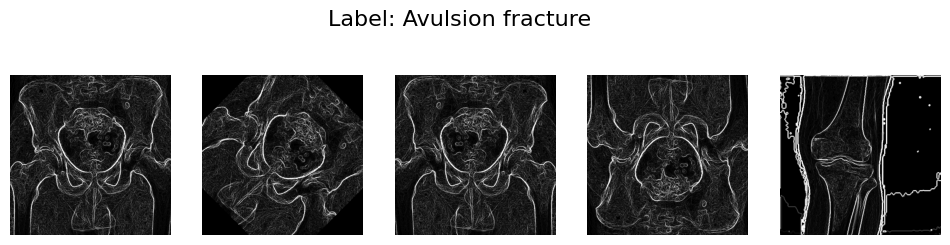

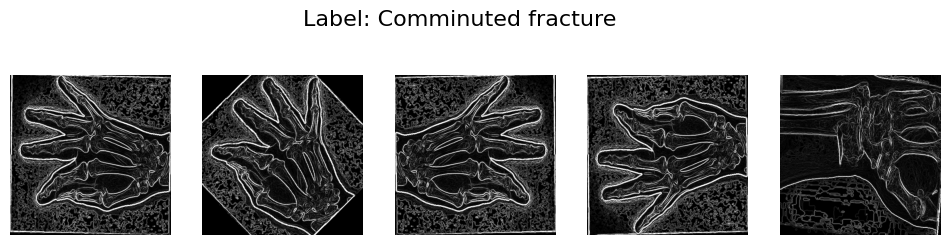

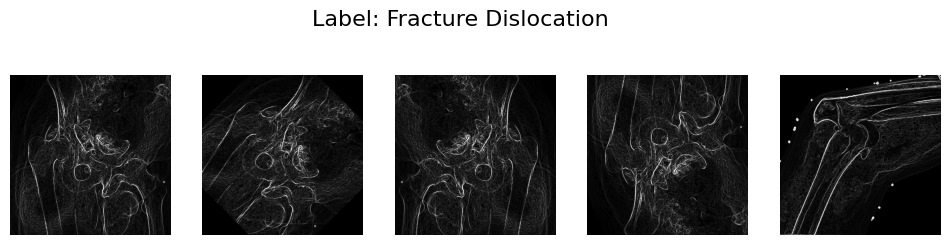

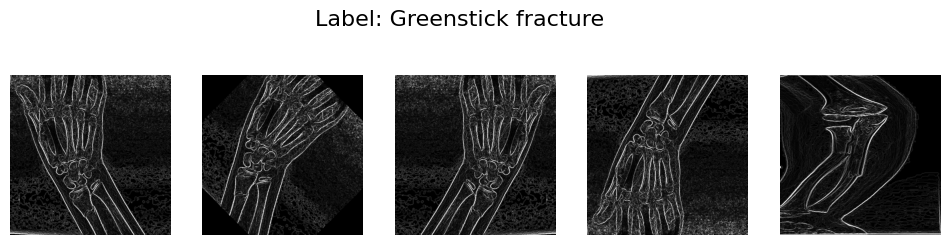

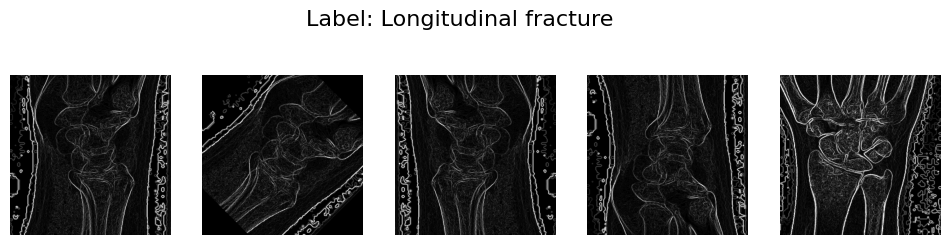

In [14]:
label_dict = {}

for img, label in zip(data_augmented, labels_augmented):
    if label not in label_dict:
        label_dict[label] = []
    if len(label_dict[label]) < 5:
        label_dict[label].append(img)

for label, images in label_dict.items():
    plt.figure(figsize=(12, 3))
    plt.suptitle(f'Label: {label}', fontsize=16)
    for i, img in enumerate(images):
        plt.subplot(1, 5, i+1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
    plt.show()

Kode ini bertujuan untuk menampilkan contoh gambar dari dataset yang telah melalui proses augmentasi, dengan menampilkan maksimal lima citra untuk setiap kelas atau label. Pertama, dibuat sebuah dictionary bernama `label_dict` yang akan menyimpan daftar citra untuk setiap label. Kemudian, dilakukan iterasi bersamaan (menggunakan `zip`) pada data gambar hasil augmentasi (`data_augmented`) dan labelnya (`labels_augmented`). Jika sebuah label belum ada di dictionary, maka dibuat entri baru dengan label tersebut sebagai kunci dan nilai berupa list kosong. Selanjutnya, jika jumlah citra yang tersimpan untuk label tersebut masih kurang dari lima, citra saat ini akan ditambahkan ke dalam list pada dictionary tersebut. Setelah proses pengelompokan selesai, untuk setiap label, kode membuat sebuah figure dengan ukuran lebar yang cukup untuk menampilkan lima gambar secara berdampingan. Judul figure diisi dengan nama label yang sedang ditampilkan. Kemudian, setiap citra dari list yang sudah dikumpulkan ditampilkan dalam subplot secara horizontal, dengan menghilangkan sumbu agar tampilan menjadi lebih bersih. Proses ini menghasilkan tampilan visual berupa kumpulan contoh gambar augmentasi untuk masing-masing kelas, yang sangat berguna untuk memeriksa kualitas dan variasi data augmentasi yang telah dibuat.


## Feature Extraction

In [15]:
def glcm(image, derajat):
    if derajat == 0:
        angles = [0]
    elif derajat == 45:
        angles = [np.pi / 4]
    elif derajat == 90:
        angles = [np.pi / 2]
    elif derajat == 135:
        angles = [3 * np.pi / 4]
    else:
        raise ValueError("Invalid angle. It should be one of the following: 0, 45, 90, 135.")

    glcm = graycomatrix(image, [1], angles, 256, symmetric=True, normed=True)
    return glcm

Fungsi `glcm` ini digunakan untuk menghitung matriks co-occurrence tingkat abu-abu (Gray Level Co-occurrence Matrix atau GLCM) dari sebuah citra berdasarkan sudut tertentu yang diberikan sebagai parameter `derajat`. Fungsi menerima input citra grayscale dan sudut dalam derajat, kemudian mengonversi sudut tersebut menjadi nilai radian yang sesuai untuk perhitungan GLCM. Sudut yang didukung adalah 0°, 45°, 90°, dan 135°, yang masing-masing diubah menjadi radian menggunakan nilai π (pi). Jika sudut yang diberikan tidak termasuk ke dalam pilihan tersebut, fungsi akan memberikan pesan error. Setelah sudut diatur, fungsi memanggil `graycomatrix` dari pustaka yang menangani ekstraksi tekstur, dengan parameter jarak piksel 1, sudut yang telah dikonversi, jumlah level abu-abu 256, dan opsi `symmetric=True` serta `normed=True` untuk menghasilkan matriks yang simetris dan ternormalisasi. Matriks GLCM yang dihasilkan menggambarkan frekuensi kemunculan pasangan piksel dengan intensitas tertentu dalam arah sudut yang dipilih, yang penting untuk analisis tekstur dalam pengolahan citra, seperti klasifikasi atau segmentasi. Fungsi kemudian mengembalikan matriks GLCM tersebut sebagai outputnya.


In [16]:
def correlation(matriks):
	return graycoprops(matriks, 'correlation')[0, 0]

Fungsi `correlation` menghitung nilai korelasi tekstur dari matriks GLCM menggunakan fungsi `graycoprops`. Nilai korelasi ini mengukur seberapa erat hubungan intensitas piksel dalam citra pada arah dan jarak tertentu. Fungsi mengembalikan satu nilai korelasi yang diperoleh dari matriks hasil perhitungan, berguna untuk analisis tekstur citra.


In [17]:
def dissimilarity(matriks):
    return graycoprops(matriks, 'dissimilarity')[0, 0]

Fungsi `dissimilarity` menghitung nilai ketidaksamaan tekstur dari matriks GLCM menggunakan `graycoprops`. Nilai ini mengukur perbedaan intensitas antar piksel dalam citra pada arah dan jarak tertentu. Fungsi mengembalikan satu nilai ketidaksamaan yang berguna untuk analisis tekstur citra.


In [18]:
def homogenity(matriks):
    return graycoprops(matriks, 'homogeneity')[0, 0]

Fungsi `homogenity` menghitung nilai homogenitas tekstur dari matriks GLCM menggunakan `graycoprops`. Nilai ini mengukur seberapa seragam intensitas piksel dalam citra pada arah dan jarak tertentu. Fungsi mengembalikan satu nilai homogenitas yang berguna untuk analisis tekstur citra.


In [19]:
def contrast(matriks):
    return graycoprops(matriks, 'contrast')[0, 0]

Fungsi `contrast` menghitung nilai kontras tekstur dari matriks GLCM menggunakan `graycoprops`. Nilai ini mengukur perbedaan intensitas piksel yang menonjol dalam citra pada arah dan jarak tertentu. Fungsi mengembalikan satu nilai kontras yang digunakan untuk analisis tekstur citra.


In [20]:
def ASM(matriks):
    return graycoprops(matriks, 'ASM')[0, 0]

Fungsi `ASM` menghitung nilai Angular Second Moment (ASM) dari matriks GLCM menggunakan `graycoprops`. Nilai ASM mengukur tingkat keseragaman atau energi tekstur dalam citra. Fungsi mengembalikan satu nilai ASM yang berguna untuk analisis tekstur citra.


In [21]:
def energy(matriks):
    return graycoprops(matriks, 'energy')[0, 0]

Fungsi `energy` menghitung nilai energi tekstur dari matriks GLCM menggunakan `graycoprops`. Nilai energi mengukur kekuatan atau keajegan pola tekstur dalam citra. Fungsi mengembalikan satu nilai energi yang berguna untuk analisis tekstur citra.


In [22]:
def entropyGlcm(matriks):
    return entropy(matriks.ravel())

Fungsi `entropyGlcm` menghitung nilai entropi dari matriks GLCM dengan menggunakan fungsi `entropy`. Matriks GLCM diubah menjadi array satu dimensi dengan `ravel()`, lalu entropi dihitung untuk mengukur tingkat ketidakpastian atau kompleksitas tekstur dalam citra. Nilai entropi ini berguna untuk analisis tekstur citra.


In [23]:
Derajat0 = []
Derajat45 = []
Derajat90 = []
Derajat135 = []
for i in range(len(data_augmented)):
    D0 = glcm(data_augmented[i], 0)
    D45 = glcm(data_augmented[i], 45)
    D90 = glcm(data_augmented[i], 90)
    D135 = glcm(data_augmented[i], 135)
    Derajat0.append(D0)
    Derajat45.append(D45)
    Derajat90.append(D90)
    Derajat135.append(D135)

Kode tersebut melakukan perhitungan matriks Gray Level Co-occurrence Matrix (GLCM) untuk setiap citra dalam dataset hasil augmentasi `data_augmented` pada empat arah sudut berbeda, yaitu 0°, 45°, 90°, dan 135°. Untuk setiap citra, fungsi `glcm` dipanggil berulang kali dengan sudut yang berbeda untuk menghasilkan empat matriks GLCM yang menggambarkan pola tekstur citra pada masing-masing arah tersebut. Setiap hasil matriks GLCM kemudian disimpan ke dalam list yang terpisah berdasarkan sudutnya: `Derajat0` untuk sudut 0°, `Derajat45` untuk sudut 45°, `Derajat90` untuk sudut 90°, dan `Derajat135` untuk sudut 135°. Dengan cara ini, dataset tekstur yang lengkap dan terorganisir berdasarkan arah sudut diperoleh, yang dapat digunakan untuk analisis lebih lanjut atau ekstraksi fitur tekstur pada berbagai orientasi citra.


In [24]:
Kontras0, Kontras45, Kontras90, Kontras135 = [], [], [], []
dissimilarity0, dissimilarity45, dissimilarity90, dissimilarity135 =  [], [], [], []
homogenity0, homogenity45, homogenity90, homogenity135 = [], [], [], []
entropy0, entropy45, entropy90, entropy135 =  [], [], [], []
ASM0, ASM45, ASM90, ASM135 =  [], [], [], []
energy0, energy45, energy90, energy135 =  [], [], [], []
correlation0, correlation45, correlation90, correlation135 = [], [], [], []


Kode ini mendefinisikan sejumlah list kosong yang nantinya akan digunakan untuk menyimpan nilai fitur tekstur hasil ekstraksi dari matriks GLCM pada empat arah sudut yang berbeda, yaitu 0°, 45°, 90°, dan 135°. Setiap fitur tekstur memiliki empat list terpisah yang sesuai dengan sudut tersebut, seperti `Kontras0`, `Kontras45`, `Kontras90`, dan `Kontras135` untuk menyimpan nilai kontras, serta hal yang sama untuk fitur dissimilarity, homogenitas, entropi, ASM (Angular Second Moment), energi, dan korelasi. Dengan struktur penyimpanan ini, data fitur tekstur yang diperoleh dari setiap sudut dapat diorganisir secara sistematis, memudahkan analisis dan pemrosesan lebih lanjut dalam pengolahan citra dan klasifikasi berbasis fitur tekstur.


In [25]:
for i in range(len(data_augmented)):
    C0 = correlation(Derajat0[i])
    correlation0.append(C0)
    C45 = correlation(Derajat45[i])
    correlation45.append(C45)
    C90 = correlation(Derajat90[i])
    correlation90.append(C90)
    C135 = correlation(Derajat135[i])
    correlation135.append(C135)

Kode ini melakukan perhitungan fitur tekstur korelasi dari matriks GLCM untuk setiap citra dalam dataset augmentasi pada empat sudut berbeda: 0°, 45°, 90°, dan 135°. Dalam setiap iterasi, fungsi `correlation` dipanggil untuk menghitung nilai korelasi dari matriks GLCM yang sudah disimpan di list `Derajat0`, `Derajat45`, `Derajat90`, dan `Derajat135` sesuai indeks citra saat ini. Nilai korelasi yang diperoleh untuk setiap sudut kemudian ditambahkan ke dalam list yang sesuai, yaitu `correlation0`, `correlation45`, `correlation90`, dan `correlation135`. Dengan cara ini, seluruh nilai korelasi untuk setiap citra dan sudut tersimpan rapi dan siap digunakan untuk analisis atau sebagai fitur input dalam model klasifikasi tekstur citra.


In [26]:
for i in range(len(data_augmented)):
    K0 = contrast(Derajat0[i])
    K45 = contrast(Derajat45[i])
    K90 = contrast(Derajat90[i])
    K135 = contrast(Derajat135[i])
    Kontras0.append(K0)
    Kontras45.append(K45)
    Kontras90.append(K90)
    Kontras135.append(K135)

Kode ini menghitung nilai fitur tekstur kontras dari matriks GLCM untuk setiap citra dalam dataset hasil augmentasi pada empat sudut berbeda: 0°, 45°, 90°, dan 135°. Pada setiap iterasi, fungsi `contrast` dipanggil untuk matriks GLCM yang disimpan dalam list `Derajat0`, `Derajat45`, `Derajat90`, dan `Derajat135` sesuai indeks citra saat ini. Nilai kontras yang diperoleh untuk setiap sudut kemudian dimasukkan ke dalam list `Kontras0`, `Kontras45`, `Kontras90`, dan `Kontras135`. Proses ini memungkinkan pengumpulan nilai kontras dari seluruh citra dan sudut secara terorganisir untuk analisis tekstur atau sebagai fitur dalam pemodelan klasifikasi citra.


In [27]:
for i in range(len(data_augmented)):
    Dis0 = dissimilarity(Derajat0[i])
    Dis45 = dissimilarity(Derajat45[i])
    Dis90 = dissimilarity(Derajat90[i])
    Dis135 = dissimilarity(Derajat135[i])
    dissimilarity0.append(Dis0)
    dissimilarity45.append(Dis45)
    dissimilarity90.append(Dis90)
    dissimilarity135.append(Dis135)

Kode ini menghitung nilai fitur tekstur dissimilarity dari matriks GLCM untuk setiap citra dalam dataset hasil augmentasi pada empat sudut berbeda: 0°, 45°, 90°, dan 135°. Pada setiap iterasi, fungsi `dissimilarity` dipanggil untuk matriks GLCM yang disimpan dalam list `Derajat0`, `Derajat45`, `Derajat90`, dan `Derajat135` sesuai indeks citra saat ini. Nilai dissimilarity yang diperoleh untuk setiap sudut kemudian ditambahkan ke list `dissimilarity0`, `dissimilarity45`, `dissimilarity90`, dan `dissimilarity135`. Dengan cara ini, nilai dissimilarity dari semua citra dan sudut tersimpan rapi untuk keperluan analisis tekstur atau sebagai fitur dalam pemodelan klasifikasi.


In [28]:
for i in range(len(data_augmented)):
    H0 = homogenity(Derajat0[i])
    H45 = homogenity(Derajat45[i])
    H90 = homogenity(Derajat90[i])
    H135 = homogenity(Derajat135[i])
    homogenity0.append(H0)
    homogenity45.append(H45)
    homogenity90.append(H90)
    homogenity135.append(H135)

Kode ini menghitung nilai fitur tekstur homogenitas dari matriks GLCM untuk setiap citra dalam dataset augmentasi pada empat sudut berbeda: 0°, 45°, 90°, dan 135°. Pada setiap iterasi, fungsi `homogenity` dipanggil untuk matriks GLCM yang disimpan di list `Derajat0`, `Derajat45`, `Derajat90`, dan `Derajat135` sesuai dengan indeks citra saat ini. Nilai homogenitas yang diperoleh untuk setiap sudut kemudian dimasukkan ke dalam list `homogenity0`, `homogenity45`, `homogenity90`, dan `homogenity135`. Proses ini memastikan pengumpulan nilai homogenitas dari seluruh citra dan sudut secara terorganisir, yang berguna untuk analisis tekstur atau sebagai fitur dalam klasifikasi citra.


In [29]:
for i in range(len(data_augmented)):  
    E0 = entropyGlcm(Derajat0[i])
    E45 = entropyGlcm(Derajat45[i])
    E90 = entropyGlcm(Derajat90[i])
    E135 = entropyGlcm(Derajat135[i])
    entropy0.append(E0)
    entropy45.append(E45)
    entropy90.append(E90)
    entropy135.append(E135)

Kode ini menghitung nilai fitur tekstur entropi dari matriks GLCM untuk setiap citra dalam dataset augmentasi pada empat sudut berbeda: 0°, 45°, 90°, dan 135°. Pada setiap iterasi, fungsi `entropyGlcm` dipanggil untuk matriks GLCM yang disimpan di list `Derajat0`, `Derajat45`, `Derajat90`, dan `Derajat135` sesuai indeks citra saat ini. Nilai entropi yang diperoleh kemudian ditambahkan ke dalam list `entropy0`, `entropy45`, `entropy90`, dan `entropy135`. Dengan cara ini, nilai entropi dari seluruh citra dan sudut tersimpan secara terorganisir untuk keperluan analisis tekstur atau sebagai fitur dalam pemodelan klasifikasi citra.


In [30]:
for i in range(len(data_augmented)):
    A0 = ASM(Derajat0[i])
    A45 = ASM(Derajat45[i])
    A90 = ASM(Derajat90[i])
    A135 = ASM(Derajat135[i])
    ASM0.append(A0)
    ASM45.append(A45)
    ASM90.append(A90)
    ASM135.append(A135)

Kode ini menghitung nilai fitur tekstur Angular Second Moment (ASM) dari matriks GLCM untuk setiap citra dalam dataset augmentasi pada empat sudut yang berbeda: 0°, 45°, 90°, dan 135°. Pada setiap iterasi, fungsi `ASM` dipanggil untuk matriks GLCM yang tersimpan di list `Derajat0`, `Derajat45`, `Derajat90`, dan `Derajat135` sesuai indeks citra saat ini. Nilai ASM yang dihasilkan kemudian ditambahkan ke list `ASM0`, `ASM45`, `ASM90`, dan `ASM135`. Proses ini memastikan pengumpulan nilai ASM dari semua citra dan sudut secara sistematis untuk analisis tekstur atau digunakan sebagai fitur dalam klasifikasi citra.


In [31]:
for i in range(len(data_augmented)):
    ER0 = energy(Derajat0[i])
    ER45 = energy(Derajat45[i])
    ER90 = energy(Derajat90[i])
    ER135 = energy(Derajat135[i])
    energy0.append(ER0)
    energy45.append(ER45)
    energy90.append(ER90)
    energy135.append(ER135)

Kode ini menghitung nilai fitur tekstur energi dari matriks GLCM untuk setiap citra dalam dataset augmentasi pada empat sudut berbeda: 0°, 45°, 90°, dan 135°. Pada setiap iterasi, fungsi `energy` dipanggil untuk matriks GLCM yang tersimpan di list `Derajat0`, `Derajat45`, `Derajat90`, dan `Derajat135` sesuai indeks citra saat ini. Nilai energi yang diperoleh kemudian dimasukkan ke dalam list `energy0`, `energy45`, `energy90`, dan `energy135`. Dengan cara ini, seluruh nilai energi dari berbagai citra dan sudut tersimpan secara terstruktur untuk analisis tekstur atau sebagai fitur dalam pemodelan klasifikasi citra.


## Write the extraction's results to CSV

In [32]:
dataTable = {'Filename': file_name_augmented, 'Label': labels_augmented,
        'Contrast0': Kontras0, 'Contrast45': Kontras45, 'Contrast90': Kontras90, 'Contrast135': Kontras135,
        'Homogeneity0': homogenity0, 'Homogeneity45': homogenity45, 'Homogeneity90': homogenity90, 'Homogeneity135': homogenity135,
        'Dissimilarity0': dissimilarity0, 'Dissimilarity45': dissimilarity45, 'Dissimilarity90': dissimilarity90, 'Dissimilarity135': dissimilarity135,
        'Entropy0': entropy0, 'Entropy45': entropy45, 'Entropy90': entropy90, 'Entropy135': entropy135,
        'ASM0': ASM0, 'ASM45': ASM45, 'ASM90': ASM90, 'ASM135': ASM135,
        'Energy0': energy0, 'Energy45': energy45, 'Energy90': energy90, 'Energy135': energy135,
        'Correlation0': correlation0, 'Correlation45': correlation45, 'Correlation90': correlation90, 'Correlation135': correlation135,
        }
df = pd.DataFrame(dataTable)
df.to_csv('hasil_ekstraksi_2.csv', index=False)

hasilEkstrak = pd.read_csv('hasil_ekstraksi_2.csv')
hasilEkstrak


,Filename,Label,Contrast0,Contrast45,Contrast90,Contrast135,Homogeneity0,Homogeneity45,Homogeneity90,Homogeneity135,...,ASM90,ASM135,Energy0,Energy45,Energy90,Energy135,Correlation0,Correlation45,Correlation90,Correlation135
0,000002_png.rf.c3e00ebc2db78bc94e644c3f6605dad0...,Avulsion fracture,969.582593,1298.355946,758.211113,1337.858767,0.096215,0.082287,0.108635,0.083282,...,0.000527,0.000390,0.021353,0.019768,0.022966,0.019759,0.728161,0.636337,0.787454,0.625273
1,000002_png.rf.c3e00ebc2db78bc94e644c3f6605dad0...,Avulsion fracture,887.703725,1171.794555,871.527814,976.095327,0.302355,0.231263,0.302156,0.236703,...,0.029544,0.029037,0.171877,0.170063,0.171883,0.170402,0.745376,0.664155,0.750078,0.720244
2,000002_png.rf.c3e00ebc2db78bc94e644c3f6605dad0...,Avulsion fracture,969.582593,1337.858767,758.211113,1298.355946,0.096215,0.083282,0.108635,0.082287,...,0.000527,0.000391,0.021353,0.019759,0.022966,0.019768,0.728161,0.625273,0.787454,0.636337
3,000002_png.rf.c3e00ebc2db78bc94e644c3f6605dad0...,Avulsion fracture,969.582593,1337.858767,758.211113,1298.355946,0.096215,0.083282,0.108635,0.082287,...,0.000527,0.000391,0.021353,0.019759,0.022966,0.019768,0.728161,0.625273,0.787454,0.636337
4,05cc2e0302957e0ad27edb6b9ffbc2_jumbo_jpg.rf.c1...,Avulsion fracture,1563.702387,2007.736191,774.019527,1828.308646,0.532482,0.513652,0.571723,0.519157,...,0.195778,0.187218,0.436032,0.432080,0.442468,0.432687,0.790691,0.731554,0.896480,0.755544
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011,The20fracture20and20Comparison20view20Emergenc...,Longitudinal fracture,221.397287,618.671807,522.636084,649.365509,0.187757,0.149265,0.182149,0.156611,...,0.002506,0.002146,0.051155,0.045525,0.050065,0.046325,0.894516,0.705557,0.751121,0.690949
2012,Transverse-fracture_Q640_jpg.rf.bd71d2eed0fbf6...,Longitudinal fracture,127.212497,592.660008,551.005229,582.385055,0.220669,0.122066,0.134562,0.120713,...,0.001273,0.001124,0.048945,0.033546,0.035684,0.033524,0.913652,0.598134,0.626666,0.605101
2013,Transverse-fracture_Q640_jpg.rf.bd71d2eed0fbf6...,Longitudinal fracture,364.415687,155.211481,359.566009,585.960819,0.346680,0.325461,0.348078,0.260911,...,0.035645,0.033211,0.188540,0.190978,0.188800,0.182238,0.731058,0.885477,0.734627,0.567650
2014,Transverse-fracture_Q640_jpg.rf.bd71d2eed0fbf6...,Longitudinal fracture,127.212497,582.385055,551.005229,592.660008,0.220669,0.120713,0.134562,0.122066,...,0.001273,0.001125,0.048945,0.033524,0.035684,0.033546,0.913652,0.605101,0.626666,0.598134


Kode ini menggabungkan berbagai data dan fitur tekstur yang telah diekstraksi dari citra ke dalam sebuah struktur data berbentuk tabel menggunakan `pandas.DataFrame`. Data yang dimasukkan meliputi nama file citra (`Filename`), label kelas (`Label`), serta nilai fitur tekstur GLCM yang diperoleh pada empat sudut rotasi (0°, 45°, 90°, 135°) untuk masing-masing fitur seperti kontras, homogenitas, dissimilaritas, entropi, ASM, energi, dan korelasi. Setelah tabel `DataFrame` terbentuk, data tersebut disimpan ke file CSV bernama `hasil_ekstraksi_3.csv` tanpa menyertakan indeks baris. Selanjutnya, file CSV yang baru disimpan dibaca kembali ke variabel `hasilEkstrak` untuk memastikan data berhasil tersimpan dan bisa digunakan untuk analisis atau proses selanjutnya. Pendekatan ini memudahkan pengelolaan data fitur tekstur dan integrasi dengan pipeline machine learning atau analisis data.


## Features Selection

pada bagian seleksi fitur ini bisa menggunakan metode seperti
- PCA
- LDA
- t-SNE
- Chi-square
- ANOVA
- Autoencoder
- correlation
- dll

berikut contoh menggunakan correlation:

Kode di bawah bertujuan untuk melakukan seleksi fitur berdasarkan korelasi antar fitur dalam dataset hasil ekstraksi. Pertama, korelasi antar semua fitur numerik dihitung dengan menggunakan metode korelasi Pearson melalui fungsi `.corr()`. Kemudian, kode menyaring fitur-fitur yang memiliki korelasi absolut lebih besar atau sama dengan ambang batas (threshold) 0.95 untuk menghindari fitur yang sangat redundan atau saling berkorelasi tinggi, yang bisa menyebabkan multikolinearitas dan mengurangi efektivitas model. Proses penyaringan dilakukan dengan menandai fitur-fitur yang perlu dipertahankan (True) atau dihilangkan (False) dalam array boolean `columns`. Setelah itu, fitur yang lolos seleksi disimpan ke variabel `x_new`, sementara label kelas disimpan di variabel `y`. Terakhir, untuk memvisualisasikan hubungan antar fitur terpilih, sebuah heatmap korelasi dibuat menggunakan seaborn dengan anotasi angka korelasi dan skema warna biru, sehingga memudahkan analisis visual terhadap hubungan antar fitur yang dipilih. Pendekatan ini membantu mengurangi dimensi data sekaligus mempertahankan fitur-fitur yang paling informatif untuk model machine learning.


<Axes: >

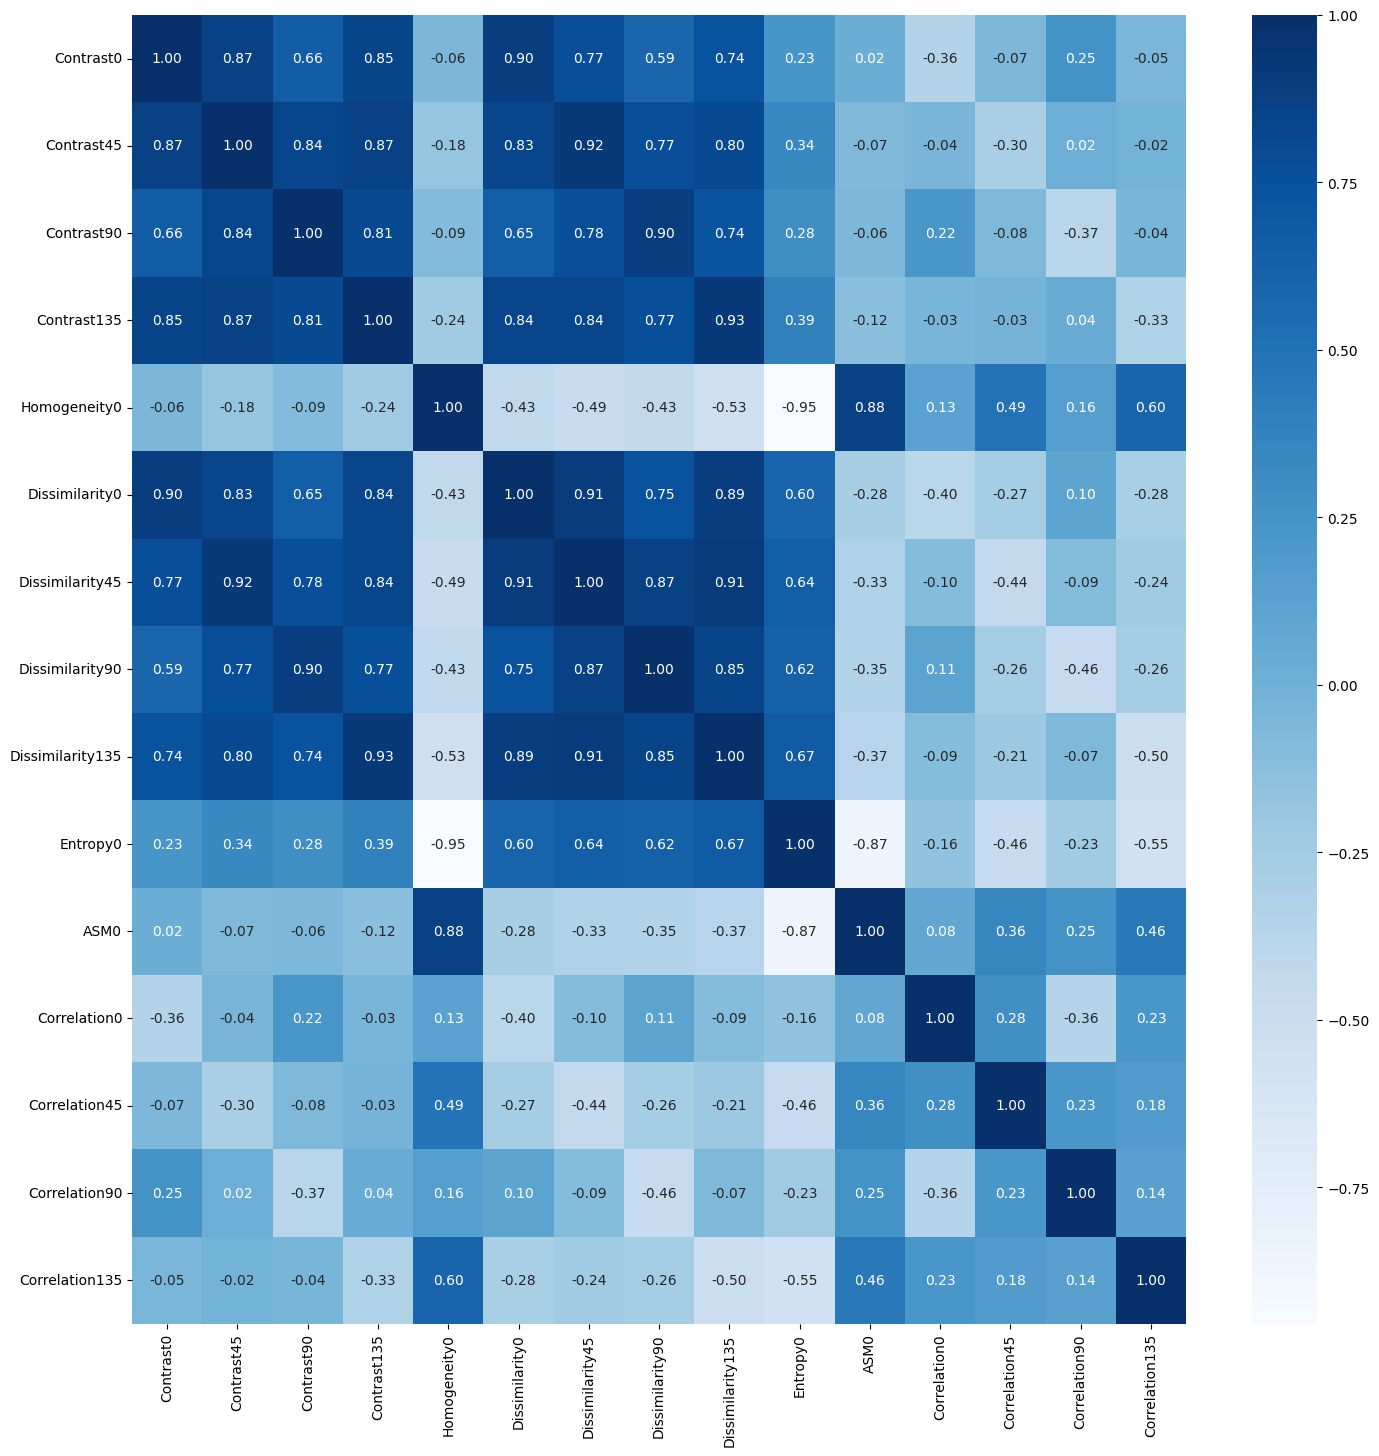

In [41]:
# Menghitung korelasi
correlation = hasilEkstrak.drop(columns=['Label','Filename']).corr()

# Menyaring fitur yang memiliki korelasi absolut lebih dari 0.95 dengan label
threshold = 0.95 # atur threshold ini untuk menentukan seberapa besar korelasi yang ingin disaring
selectionFeature = []
columns = np.full((correlation.shape[0],), True, dtype=bool)
for i in range(correlation.shape[0]):
	for j in range(i+1, correlation.shape[0]):
		if correlation.iloc[i,j] >= threshold:
			if columns[j]:
				columns[j] = False
select = hasilEkstrak.drop(columns=['Label','Filename']).columns[columns]
x_new = hasilEkstrak[select]
x_new
y = hasilEkstrak['Label']
plt.figure(figsize=(17,17))
sns.heatmap(x_new.corr(), annot=True, cmap='Blues', fmt=".2f")

## Splitting Data

In [42]:
# ubah bagian test_size sesuai kebutuhan
# 0.3 = 30% data untuk testing (train/test 70/30)
# 0.2 = 20% data untuk testing (train/test 80/20)
X_train, X_test, y_train, y_test = train_test_split(x_new, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)

(1612, 15)
(404, 15)


Kode ini melakukan pembagian dataset menjadi dua bagian utama yaitu data pelatihan (training) dan data pengujian (testing) menggunakan fungsi `train_test_split` dari library scikit-learn. Parameter `test_size=0.2` menunjukkan bahwa 20% data akan digunakan sebagai data uji, sementara 80% sisanya digunakan untuk pelatihan model. Argumen `random_state=42` memastikan pembagian data yang konsisten dan dapat direproduksi di setiap kali kode dijalankan. Setelah pembagian, ukuran (shape) data pelatihan dan pengujian dicetak, yaitu 1612 sampel dengan 12 fitur untuk data pelatihan dan 404 sampel dengan 12 fitur untuk data pengujian. Proses ini penting agar model dapat dilatih pada sebagian data dan diuji pada data yang belum pernah dilihat sebelumnya, guna mengevaluasi performa model secara objektif.


## Feature Normalization

berikut metode normalisasi yang bisa digunakan:
- Min-Max Scaling
- Standardization (Z-score)
- Robust Scaling
- MaxAbsScaler
- dll

berikut contoh menggunakan Standardization (Z-score):

In [43]:
# normalisasi mean std
X_test = (X_test - X_train.mean()) / X_train.std()
X_train = (X_train - X_train.mean()) / X_train.std()

Kode ini melakukan normalisasi fitur pada data pelatihan (`X_train`) dan data pengujian (`X_test`) dengan metode standar (standardization) menggunakan mean dan standar deviasi dari data pelatihan. Proses ini mengubah setiap fitur sehingga memiliki nilai rata-rata (mean) nol dan standar deviasi satu. Dengan cara ini, fitur-fitur menjadi lebih seimbang dan tidak dipengaruhi oleh skala nilai yang berbeda-beda. Penting untuk menghitung mean dan standar deviasi hanya dari data pelatihan agar model tidak "melihat" informasi dari data pengujian, sehingga hasil evaluasi tetap valid dan bebas bias. Normalisasi membantu algoritma machine learning bekerja lebih efektif dan mempercepat konvergensi pelatihan.


## MODELING

### DEFINE MODELING

In [44]:
def generateClassificationReport(y_true, y_pred):
	print(classification_report(y_true, y_pred))
	print(confusion_matrix(y_true, y_pred))
	print('Accuracy:', accuracy_score(y_true, y_pred))

# Define classifiers
rf = RandomForestClassifier(n_estimators=5, random_state=42)
svm = SVC(kernel='rbf', random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)

Fungsi `generateClassificationReport` dibuat untuk menampilkan hasil evaluasi model klasifikasi secara lengkap. Fungsi ini menerima dua parameter, yaitu `y_true` (label asli) dan `y_pred` (label hasil prediksi model). Fungsi ini kemudian mencetak laporan klasifikasi (`classification_report`) yang berisi metrik seperti precision, recall, dan f1-score untuk setiap kelas, serta confusion matrix yang menunjukkan jumlah prediksi benar dan salah untuk tiap kelas. Selain itu, fungsi juga mencetak akurasi keseluruhan dari prediksi model. Selanjutnya, beberapa model klasifikasi didefinisikan, yaitu Random Forest (`rf`) dengan 5 pohon keputusan, Support Vector Machine (`svm`) dengan kernel radial basis function (rbf), dan K-Nearest Neighbors (`knn`) dengan 5 tetangga terdekat. Ketiga model ini umum digunakan dalam tugas klasifikasi dan disiapkan untuk pelatihan dan evaluasi pada dataset yang tersedia.

### Train Random Forest Classifier

In [45]:
# Train Random Forest Classifier
rf.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("------Training Set------")
y_pred = rf.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = rf.predict(X_test)
generateClassificationReport( y_test, y_pred)

------Training Set------
                       precision    recall  f1-score   support

    Avulsion fracture       0.98      0.98      0.98       293
  Comminuted fracture       0.97      0.98      0.98       385
 Fracture Dislocation       0.98      0.97      0.98       366
  Greenstick fracture       0.97      0.96      0.96       331
Longitudinal fracture       0.97      0.97      0.97       237

             accuracy                           0.97      1612
            macro avg       0.97      0.97      0.97      1612
         weighted avg       0.97      0.97      0.97      1612

[[288   0   1   3   1]
 [  4 378   0   1   2]
 [  2   4 356   4   0]
 [  1   6   4 317   3]
 [  0   2   3   3 229]]
Accuracy: 0.9727047146401985

------Testing Set------
                       precision    recall  f1-score   support

    Avulsion fracture       0.67      0.82      0.74        79
  Comminuted fracture       0.73      0.76      0.74        87
 Fracture Dislocation       0.75      0.61   

Kode ini menjalankan proses pelatihan dan evaluasi model Random Forest Classifier pada dataset yang telah dipersiapkan. Pertama, model Random Forest (`rf`) dilatih menggunakan data training (`X_train` dan `y_train`) dengan metode `fit()`. Setelah pelatihan selesai, model digunakan untuk memprediksi label pada data training itu sendiri, dan hasil prediksi ini dibandingkan dengan label asli (`y_train`) untuk mengevaluasi performa model pada data yang sudah dilihat selama pelatihan. Evaluasi tersebut ditampilkan menggunakan fungsi `generateClassificationReport`, yang mencakup metrik seperti precision, recall, f1-score, confusion matrix, dan akurasi. Selanjutnya, model yang sudah dilatih digunakan untuk memprediksi label pada data testing (`X_test`) yang sebelumnya tidak pernah dilihat oleh model. Hasil prediksi pada data testing ini dibandingkan dengan label asli testing (`y_test`) dan dievaluasi kembali menggunakan fungsi yang sama untuk mengetahui seberapa baik model dapat menggeneralisasi pada data baru. Output ini memberikan gambaran lengkap tentang performa model baik pada data pelatihan maupun data pengujian.


### Train SVM Classifier

In [46]:
# Train SVM Classifier
svm.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = svm.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = svm.predict(X_test)
generateClassificationReport( y_test, y_pred)


------Training Set------
                       precision    recall  f1-score   support

    Avulsion fracture       0.43      0.44      0.43       293
  Comminuted fracture       0.49      0.55      0.52       385
 Fracture Dislocation       0.38      0.60      0.46       366
  Greenstick fracture       0.51      0.31      0.39       331
Longitudinal fracture       0.61      0.24      0.34       237

             accuracy                           0.45      1612
            macro avg       0.48      0.43      0.43      1612
         weighted avg       0.48      0.45      0.44      1612

[[128  44  97  13  11]
 [ 52 212  83  33   5]
 [ 49  55 220  38   4]
 [ 50  54 106 104  17]
 [ 18  68  79  15  57]]
Accuracy: 0.4472704714640198

------Testing Set------
                       precision    recall  f1-score   support

    Avulsion fracture       0.39      0.38      0.39        79
  Comminuted fracture       0.46      0.54      0.49        87
 Fracture Dislocation       0.36      0.54  

Kode ini melakukan pelatihan dan evaluasi model Support Vector Machine (SVM) pada dataset yang telah disiapkan. Pertama, model SVM (`svm`) dilatih menggunakan data training (`X_train` dan `y_train`) dengan memanggil metode `fit()`. Setelah pelatihan selesai, model digunakan untuk memprediksi label pada data training itu sendiri, kemudian hasil prediksi dibandingkan dengan label asli (`y_train`) untuk menilai kinerja model pada data yang sudah dikenalnya. Evaluasi performa dilakukan dengan fungsi `generateClassificationReport`, yang menampilkan metrik seperti precision, recall, f1-score, confusion matrix, dan akurasi. Selanjutnya, model yang sudah dilatih digunakan untuk memprediksi label pada data testing (`X_test`) yang belum pernah dilihat sebelumnya oleh model. Hasil prediksi pada data testing ini dievaluasi kembali dengan fungsi yang sama untuk mengetahui seberapa baik model dapat menggeneralisasi dan memprediksi data baru. Proses ini memberikan gambaran lengkap tentang kemampuan model SVM dalam mengenali pola pada data pelatihan dan pengujian.


### Train KNN Classifier

In [47]:
# Train KNN Classifier
knn.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = knn.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = knn.predict(X_test)
generateClassificationReport( y_test, y_pred)



------Training Set------
                       precision    recall  f1-score   support

    Avulsion fracture       0.62      0.76      0.69       293
  Comminuted fracture       0.67      0.79      0.73       385
 Fracture Dislocation       0.73      0.71      0.72       366
  Greenstick fracture       0.71      0.61      0.66       331
Longitudinal fracture       0.75      0.50      0.60       237

             accuracy                           0.69      1612
            macro avg       0.70      0.68      0.68      1612
         weighted avg       0.70      0.69      0.69      1612

[[223  19  22  17  12]
 [ 36 305  18  18   8]
 [ 30  46 260  17  13]
 [ 51  44  26 203   7]
 [ 17  41  29  31 119]]
Accuracy: 0.6885856079404467

------Testing Set------
                       precision    recall  f1-score   support

    Avulsion fracture       0.35      0.49      0.41        79
  Comminuted fracture       0.49      0.51      0.50        87
 Fracture Dislocation       0.48      0.43  

Kode ini melatih model KNN dengan data training, lalu mengevaluasi performanya pada data training dan testing menggunakan metrik seperti akurasi dan confusion matrix. Fungsi `generateClassificationReport` digunakan untuk menampilkan hasil evaluasi tersebut, sehingga kita dapat melihat seberapa baik model mengenali pola pada data yang sudah dan belum dilihat.


## Evaluation With Confusion Matrix

Fungsi `plot_confusion_matrix` digunakan untuk membuat dan menampilkan matriks kebingungan (confusion matrix) dari hasil prediksi model terhadap data sebenarnya. Matriks ini memberikan gambaran visual tentang performa klasifikasi, dengan menunjukkan jumlah prediksi yang benar dan salah untuk setiap kelas. Dalam kode tersebut, fungsi ini dipanggil untuk masing-masing model — Random Forest, SVM, dan KNN — menggunakan data testing. Setiap plot matriks kebingungan diberi judul sesuai nama model yang diuji, sehingga memudahkan perbandingan visual performa ketiga model tersebut pada data uji.


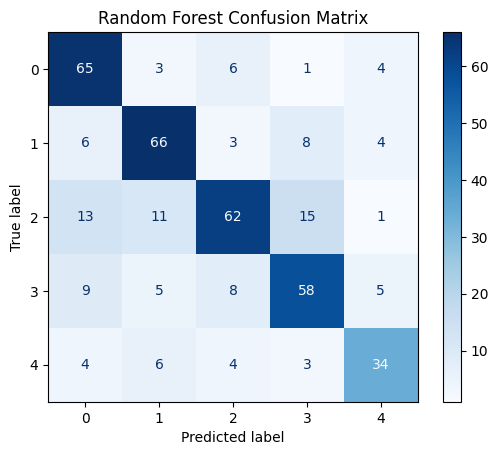

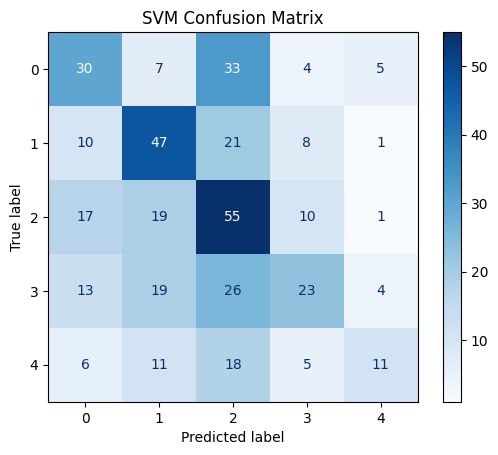

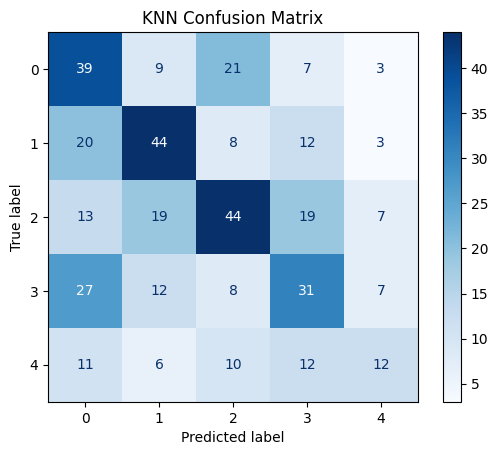

In [48]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

# Plot confusion matrix for Random Forest
plot_confusion_matrix(y_test, rf.predict(X_test), "Random Forest Confusion Matrix")
# Plot confusion matrix for SVM
plot_confusion_matrix(y_test, svm.predict(X_test), "SVM Confusion Matrix")
# Plot confusion matrix for KNN
plot_confusion_matrix(y_test, knn.predict(X_test), "KNN Confusion Matrix")

### ANALISIS HASIL :

Pada percobaan ini, model Random Forest menunjukkan performa terbaik dibandingkan KNN dan SVM, dengan akurasi mencapai sekitar 97% pada data training dan 71% pada data testing. Peningkatan akurasi ini dipengaruhi oleh perubahan proses preprocessing, terutama penggunaan sharpening dan deteksi tepi Sobel. Proses sharpening yang dilakukan sebelum deteksi tepi berfungsi untuk meningkatkan detail dan kontras pada citra, sehingga kontur tulang dan retakan yang menjadi ciri khas fraktur dapat terlihat lebih jelas. Selanjutnya, deteksi tepi Sobel membantu mengekstrak fitur tepi tersebut secara lebih efektif sehingga model memperoleh informasi yang lebih representatif dan informatif.

Sebaliknya, model KNN dan SVM menunjukkan performa yang lebih rendah. KNN, yang sensitif terhadap dimensi fitur dan keberadaan noise, cenderung kesulitan jika fitur yang dihasilkan kurang terstruktur atau kurang relevan. Sedangkan SVM, yang mengandalkan pemisahan data secara linear atau kernel yang tepat, mungkin kurang optimal dalam menghadapi data yang kompleks dan non-linear seperti pada kasus citra fraktur ini. Perbedaan hasil ini mengindikasikan bahwa proses preprocessing, khususnya sharpening dan deteksi tepi Sobel, sangat berpengaruh dalam meningkatkan kualitas fitur yang digunakan oleh model. Pada percobaan sebelumnya, apabila proses sharpening dan deteksi tepi tidak dilakukan atau kurang optimal, maka fitur yang dihasilkan kurang tajam dan informatif, sehingga menurunkan performa klasifikasi.

Dengan demikian, dapat disimpulkan bahwa kombinasi preprocessing sharpening dan deteksi tepi Sobel berhasil meningkatkan kualitas fitur sehingga Random Forest mampu belajar pola dengan lebih baik dan menghasilkan akurasi yang lebih tinggi. Meski demikian, model KNN dan SVM masih belum mampu memanfaatkan fitur tersebut secara optimal, sehingga performanya relatif lebih rendah dibanding Random Forest.